# Métodos matemáticos para físicos I

## Métrica, datos y calibración inteligente

Autores:
* Nicolás Toledo Parra, 2200017
* Gabriela Sánchez Ariza, 2200816 

***Introducción***: Estamos viviendo una época de desarrollo explosivo de sensores que pueblan y generan datos en todas las facetas de nuestra cotidianidad. Estos sensores de bajo costo forman parte de dispositivos de la llamada revolución de la *Internet de las cosas, IoT*. Muchas veces estos sensores no son lo suficientemente precisos y deben ser calibrados con un patron de referencia. En este ejercicio se hará uso de las medidas de referencia de concentración de material particulado PM2,5 del archivo *Datos estaciones AMB*, y del archivo *mediciones* que contiene los registros de las estaciones de bajo costo. El problema de este trabajo está en cuantificar cuál es el error de medición del sensor de bajo costo y, como calibrarlo para que podamos establecer nuevas lecturas que sean mas precisas.

Para la presentación de este trabajo se realizó la división del código en tres secciones que corresponden a:
* [1. Reorganización de los datos](#section-1)
* [2. Promedio móvil](#section-2)
* [3. Regresión lineal de los datos](#section-3)

In [1]:
#Importanción de librerias importantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, time, datetime
from numpy.linalg import inv

## 1. Reorganización de los datos <a class="anchor" id="section-1"></a>

### Lectura de datos individuales

Se leen los datos de estaciones AMB y los del sensor de bajo costo.

In [2]:
#A continuación, se leen los datos en DataFrames.
data=pd.read_excel('Datosasig2/ju/Datos_Estaciones_AMB_limpios.xlsx')

In [3]:
medición1=pd.read_csv('Datosasig2/ju/med_1.txt')
medición2=pd.read_csv('Datosasig2/ju/med_2.txt')
medición6=pd.read_csv('Datosasig2/ju/med_6.txt')
medición7=pd.read_csv('Datosasig2/ju/med_7.txt')
medición8=pd.read_csv('Datosasig2/ju/med_8.txt')
medición9=pd.read_csv('Datosasig2/ju/med_9.txt')
medición10=pd.read_csv('Datosasig2/ju/med_10.txt')

In [4]:
data = data.rename(columns={'fecha_hora_med' : 'Tiempo'})
data = data.rename(columns={'PM2.5' : 'PM2.5_AMB'})

Se unen los datos de mediciones leídos anteriormente en un solo dataframe.

In [5]:
all_mediciones=[medición1,medición2,medición6,medición7,medición8,medición9,medición10]
all_mediciones= pd.concat(all_mediciones)
all_mediciones = all_mediciones.rename(columns={'fecha_hora_med' : 'Tiempo'})
all_mediciones = all_mediciones.rename(columns={'valor' : 'PM2.5_MED'})
all_mediciones

,Tiempo,id_parametro,PM2.5_MED
0,2018-12-01T04:01:10.470Z,pm25_a,11.714286
1,2018-12-01T03:01:21.774Z,pm25_a,13.999999
2,2018-12-01T02:01:11.940Z,pm25_a,17.000000
3,2018-12-01T01:01:11.357Z,pm25_a,17.571430
4,2018-12-01T00:01:11.955Z,pm25_a,15.285713
...,...,...,...
740,2019-08-01T09:02:50.208Z,pm25_a,32.416668
741,2019-08-01T08:02:50.208Z,pm25_a,42.749996
742,2019-08-01T07:02:51.208Z,pm25_a,28.416664
743,2019-08-01T06:03:00.526Z,pm25_a,30.250000


In [6]:
data=data.dropna() #Se eliminan filas vacías

In [7]:
data

,Tiempo,PM2.5_AMB
0,2018-10-01 00:00:00,6.4
1,2018-10-01 01:00:00,6.4
2,2018-10-01 02:00:00,6.7
3,2018-10-01 03:00:00,6.0
4,2018-10-01 04:00:00,7.3
...,...,...
7090,2019-08-31 19:00:00,20.4
7091,2019-08-31 20:00:00,18.7
7092,2019-08-31 21:00:00,22.8
7093,2019-08-31 22:00:00,25.2


In [8]:
data['Tiempo'] = pd.to_datetime(data['Tiempo']) # Se convierten las fechas a formato datetime
data = data.set_index('Tiempo')

In [9]:
all_mediciones['Tiempo'] = pd.to_datetime(all_mediciones['Tiempo'], unit='ns').dt.tz_localize(None)
all_mediciones= all_mediciones.set_index('Tiempo')

In [10]:
data_hora = data.resample('H').mean() # Se realiza un remuestreo para organizar los datos de tiempo de forma que queden
data_dia = data.resample('D').mean()  # intervalos de tiempo más cómodos y convenientes para usar.   
data_mes = data.resample('M').mean()

In [11]:
all_mediciones_hora = all_mediciones.resample('H').mean()
all_mediciones_dia= all_mediciones.resample('D').mean()
all_mediciones_mes= all_mediciones.resample('M').mean()

In [12]:
data_hora

,PM2.5_AMB
Tiempo,
2018-10-01 00:00:00,6.4
2018-10-01 01:00:00,6.4
2018-10-01 02:00:00,6.7
2018-10-01 03:00:00,6.0
2018-10-01 04:00:00,7.3
...,...
2019-08-31 19:00:00,20.4
2019-08-31 20:00:00,18.7
2019-08-31 21:00:00,22.8


In [13]:
data_mes

,PM2.5_AMB
Tiempo,
2018-10-31,8.049394
2018-11-30,10.120972
2018-12-31,17.983423
2019-01-31,20.299730
2019-02-28,30.945763
2019-03-31,31.229310
2019-04-30,17.820781
2019-05-31,10.801478
2019-06-30,11.613769


In [14]:
data_dia

,PM2.5_AMB
Tiempo,
2018-10-01,8.333333
2018-10-02,6.854167
2018-10-03,9.212500
2018-10-04,8.683333
2018-10-05,8.070833
...,...
2019-08-27,16.879167
2019-08-28,11.879167
2019-08-29,15.029167


In [15]:
all_mediciones_hora

,PM2.5_MED
Tiempo,
2018-11-03 23:00:00,8.680555
2018-11-04 00:00:00,8.472222
2018-11-04 01:00:00,6.909722
2018-11-04 02:00:00,6.347222
2018-11-04 03:00:00,7.833333
...,...
2019-09-01 00:00:00,6.166667
2019-09-01 01:00:00,7.833333
2019-09-01 02:00:00,5.416667


A continuación se fusionan las tablas de las estaciones AMB y de las medidas del sensor de bajo costo en orden de horas.

In [16]:
data_comparison_hora=pd.merge(all_mediciones_hora, data_hora, on='Tiempo')
data_comparison_hora=data_comparison_hora.dropna()
data_comparison_hora

,PM2.5_MED,PM2.5_AMB
Tiempo,,
2018-11-03 23:00:00,8.680555,11.5
2018-11-04 00:00:00,8.472222,12.2
2018-11-04 01:00:00,6.909722,12.6
2018-11-04 02:00:00,6.347222,12.1
2018-11-04 03:00:00,7.833333,8.8
...,...,...
2019-08-31 19:00:00,26.833332,20.4
2019-08-31 20:00:00,32.333336,18.7
2019-08-31 21:00:00,32.416668,22.8


In [17]:
data_comparison_hora_cortada = data_comparison_hora.iloc[470::] #Se cortan una parte de los datos, esto para mejorar la
data_comparison_hora_cortada                                    #visualización de posteriores gráficas.

,PM2.5_MED,PM2.5_AMB
Tiempo,,
2019-04-11 17:00:00,23.500000,18.5
2019-04-11 18:00:00,22.083334,18.9
2019-04-11 19:00:00,25.250000,18.0
2019-04-11 20:00:00,28.749998,18.4
2019-04-11 21:00:00,29.000000,19.3
...,...,...
2019-08-31 19:00:00,26.833332,20.4
2019-08-31 20:00:00,32.333336,18.7
2019-08-31 21:00:00,32.416668,22.8


In [18]:
data_comparison_dia=pd.merge(all_mediciones_dia, data_dia, on='Tiempo') 
data_comparison_dia=data_comparison_dia.dropna()
data_comparison_dia

,PM2.5_MED,PM2.5_AMB
Tiempo,,
2018-11-03,8.680555,10.412500
2018-11-04,9.225405,9.695833
2018-11-05,5.034965,6.233333
2018-11-06,9.110119,7.537500
2018-11-07,14.696632,9.250000
...,...,...
2019-08-27,20.430556,16.879167
2019-08-28,13.711806,11.879167
2019-08-29,18.611111,15.029167


In [19]:
data_comparison_dia.iloc[26]
data_comparison_dia_cortada = data_comparison_dia.iloc[26::]

In [20]:
data_comparison_mes=pd.merge(all_mediciones_mes, data_mes, on='Tiempo')
data_comparison_mes=data_comparison_mes.dropna()
data_comparison_mes

,PM2.5_MED,PM2.5_AMB
Tiempo,,
2018-11-30,11.165306,10.120972
2018-12-31,20.629088,17.983423
2019-04-30,16.336947,17.820781
2019-05-31,9.821778,10.801478
2019-06-30,13.707743,11.613769
2019-07-31,14.123609,12.713710
2019-08-31,20.040492,15.839382


En seguida se grafican los datos de concentración del material particulado PM2.5 tanto para los datos medidos como para los datos de referencia.

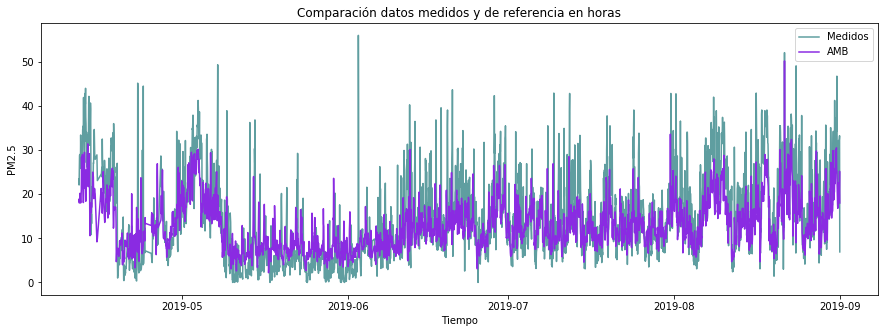

In [21]:
plt.figure(figsize=(15,5))
plt.plot(data_comparison_hora_cortada["PM2.5_MED"], color='cadetblue', label='Medidos')
plt.plot(data_comparison_hora_cortada["PM2.5_AMB"], color='blueviolet', label='AMB')
plt.title("Comparación datos medidos y de referencia en horas")
plt.xlabel("Tiempo")
plt.ylabel("PM2.5")
plt.legend()

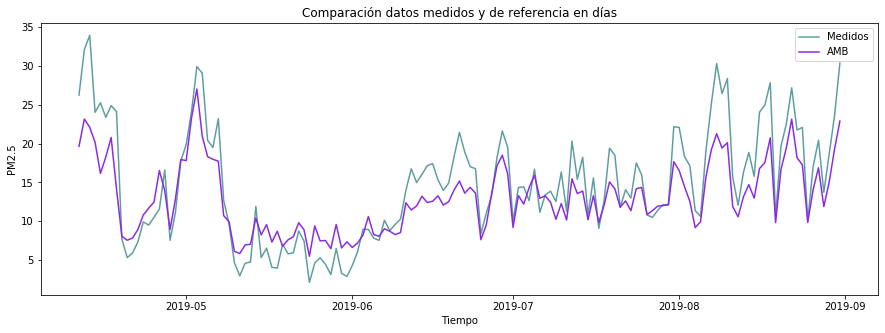

In [22]:
plt.figure(figsize=(15,5))
plt.plot(data_comparison_dia_cortada["PM2.5_MED"], color='cadetblue', label='Medidos')
plt.plot(data_comparison_dia_cortada["PM2.5_AMB"], color='blueviolet', label='AMB')
plt.title("Comparación datos medidos y de referencia en días")
plt.xlabel("Tiempo")
plt.ylabel("PM2.5")
plt.legend()

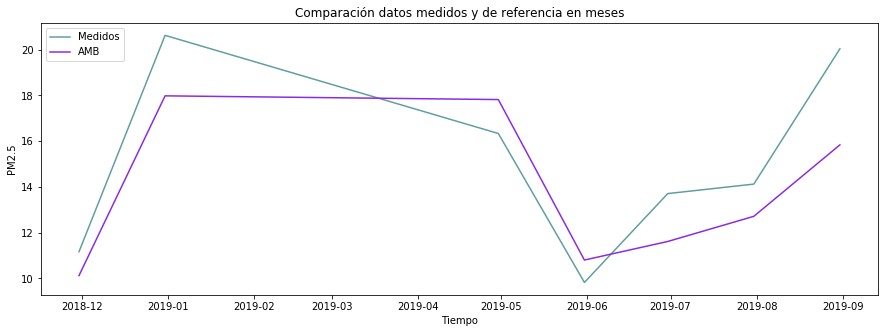

In [23]:
plt.figure(figsize=(15,5))
plt.plot(data_comparison_mes["PM2.5_MED"], color='cadetblue', label='Medidos')
plt.plot(data_comparison_mes["PM2.5_AMB"], color='blueviolet', label='AMB')
plt.title("Comparación datos medidos y de referencia en meses")
plt.xlabel("Tiempo")
plt.ylabel("PM2.5")
plt.legend()

## 2. Promedio móvil <a class="anchor" id="section-2"></a>

Las siguientes líneas calculan una media móvil para los datos en orden de horas y de días con sus respectivos errores. El tamaño de la ventana en 5 y se calculan los promedios con pasos de 1.

In [24]:
data_comparison_hora_cortada_med = data_comparison_hora_cortada['PM2.5_MED'].rolling(5).mean()
data_comparison_hora_cortada['Prom_mov_MED'] = data_comparison_hora_cortada_med
data_comparison_hora_cortada_amb = data_comparison_hora_cortada['PM2.5_AMB'].rolling(5).mean()
data_comparison_hora_cortada['Prom_mov_AMB'] = data_comparison_hora_cortada_amb
data_comparison_hora_cortada['Error_Prom_mov'] = abs(data_comparison_hora_cortada['Prom_mov_AMB']-data_comparison_hora_cortada['Prom_mov_MED'])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [25]:
data_comparison_dia_cortada_med = data_comparison_dia_cortada['PM2.5_MED'].rolling(5).mean()
data_comparison_dia_cortada['Prom_mov_MED'] = data_comparison_dia_cortada_med
data_comparison_dia_cortada_amb = data_comparison_dia_cortada['PM2.5_AMB'].rolling(5).mean()
data_comparison_dia_cortada['Prom_mov_AMB'] = data_comparison_dia_cortada_amb
data_comparison_dia_cortada['Error_Prom_mov'] = abs(data_comparison_dia_cortada['Prom_mov_AMB']-data_comparison_dia_cortada['Prom_mov_MED'])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

A continuación se pueden visualizar las tablas en escalas de horas y días, estas contienen las concentraciones de PM2.5 tanto de referencia como medidas, así como sus promedios móviles y el respectivo error para el promedio móvil.

In [26]:
data_comparison_hora_cortada

,PM2.5_MED,PM2.5_AMB,Prom_mov_MED,Prom_mov_AMB,Error_Prom_mov
Tiempo,,,,,
2019-04-11 17:00:00,23.500000,18.5,NaN,NaN,NaN
2019-04-11 18:00:00,22.083334,18.9,NaN,NaN,NaN
2019-04-11 19:00:00,25.250000,18.0,NaN,NaN,NaN
2019-04-11 20:00:00,28.749998,18.4,NaN,NaN,NaN
2019-04-11 21:00:00,29.000000,19.3,25.716666,18.62,7.096666
...,...,...,...,...,...
2019-08-31 19:00:00,26.833332,20.4,27.100000,20.20,6.900000
2019-08-31 20:00:00,32.333336,18.7,29.366667,20.34,9.026667
2019-08-31 21:00:00,32.416668,22.8,30.083334,21.12,8.963334


In [27]:
data_comparison_dia_cortada

,PM2.5_MED,PM2.5_AMB,Prom_mov_MED,Prom_mov_AMB,Error_Prom_mov
Tiempo,,,,,
2019-04-11,26.226190,19.637500,NaN,NaN,NaN
2019-04-12,32.108696,23.154167,NaN,NaN,NaN
2019-04-13,33.920290,22.091667,NaN,NaN,NaN
2019-04-14,24.008772,20.162500,NaN,NaN,NaN
2019-04-15,25.250000,16.154167,28.302790,20.240000,8.062790
...,...,...,...,...,...
2019-08-27,20.430556,16.879167,18.256944,15.243333,3.013611
2019-08-28,13.711806,11.879167,16.652778,13.981667,2.671111
2019-08-29,18.611111,15.029167,15.959722,13.539167,2.420556


Se sobrepone la media móvil y los datos de PM2.5 y se grafica, esto se hace tanto para los datos medidos como para los datos de referencia. La escala usada es en días, ya que permite una visualización más clara.

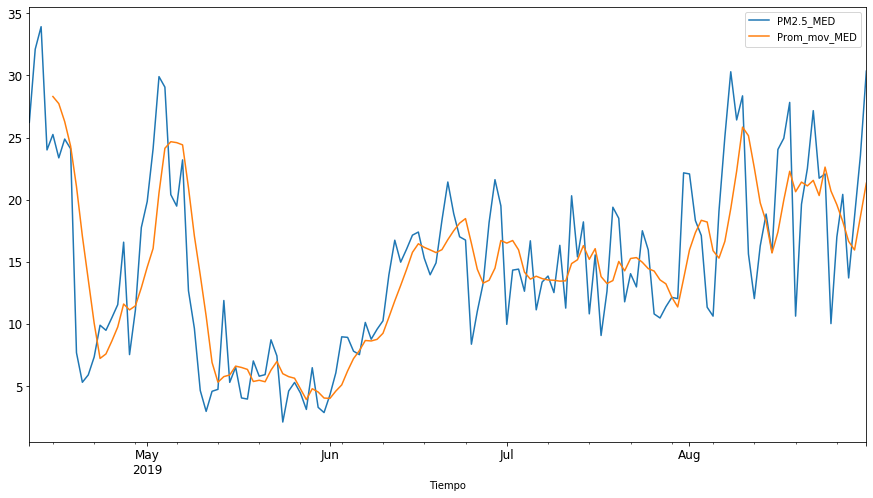

In [28]:
plot = data_comparison_dia_cortada[['PM2.5_MED', 'Prom_mov_MED']].plot(figsize=(15, 8), fontsize=12)

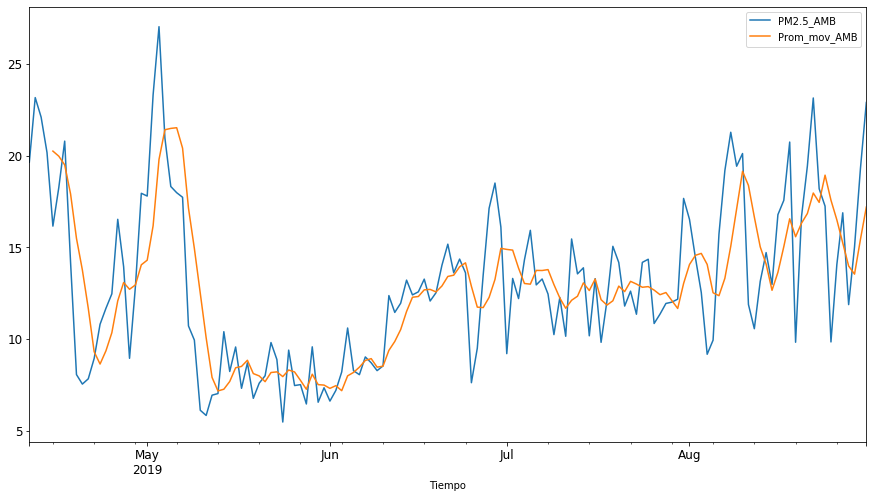

In [29]:
plot = data_comparison_dia_cortada[['PM2.5_AMB', 'Prom_mov_AMB']].plot(figsize=(15, 8), fontsize=12)

Distancia Euclidiana promedios

In [30]:
np.sqrt(np.sum((data_comparison_hora_cortada["Prom_mov_MED"]-data_comparison_hora_cortada["Prom_mov_AMB"])**2))

301.8506978909095

In [31]:
np.sqrt(np.sum((data_comparison_dia_cortada["Prom_mov_MED"]-data_comparison_dia_cortada["Prom_mov_AMB"])**2))

36.17696775820832

## 3. Regresión lineal de los datos <a class="anchor" id="section-3"></a>

Para realizar una regresión lineal por el método de mínimos cuadrados se partirá en dos mitades el conjunto de datos en para cada escala de tiempo:

Horas:

In [32]:
data_comparison_hora1 = data_comparison_hora.iloc[0:1898:]
data_comparison_hora2 = data_comparison_hora.iloc[1898:3797:]

In [33]:
X1 = np.array([np.ones(len(data_comparison_hora1["PM2.5_MED"])), data_comparison_hora1["PM2.5_MED"]]).T
a1 = inv(X1.T @ X1) @ X1.T @ data_comparison_hora1["PM2.5_AMB"] ### Fórmula para minimizar los cuadrados

In [34]:
### Predicción
x1_predict = np.linspace(data_comparison_hora1["PM2.5_MED"].min(), data_comparison_hora1["PM2.5_MED"].max(), num=100)
y1_predict = a1[0] + a1[1] * x1_predict ### Recta

In [35]:
X2 = np.array([np.ones(len(data_comparison_hora2["PM2.5_MED"])), data_comparison_hora2["PM2.5_MED"]]).T
a2 = inv(X2.T @ X2) @ X2.T @ data_comparison_hora2["PM2.5_AMB"] ### Fórmula para minimizar los cuadrados

In [36]:
### Predicción
x2_predict = np.linspace(data_comparison_hora2["PM2.5_MED"].min(), data_comparison_hora2["PM2.5_MED"].max(), num=100)
y2_predict = a2[0] + a2[1] * x2_predict ### Recta

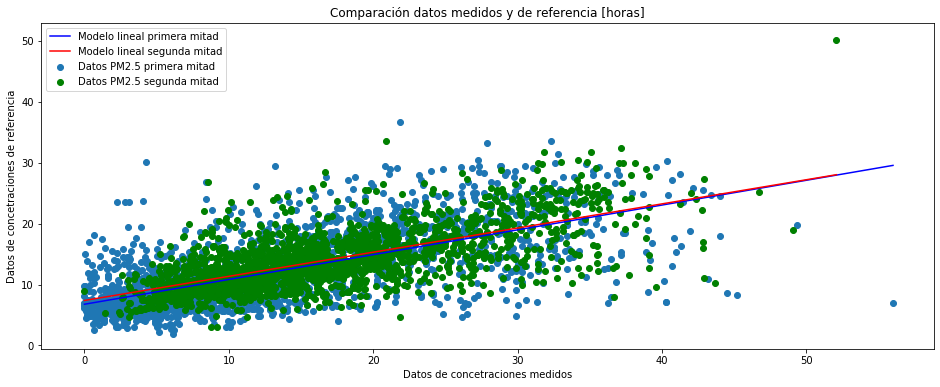

In [37]:
plt.figure(figsize=(16,6))
#Se grafican los puntos con las concetraciones PM2.5
plt.scatter(data_comparison_hora1["PM2.5_MED"], data_comparison_hora1["PM2.5_AMB"], label="Datos PM2.5 primera mitad")
plt.scatter(data_comparison_hora2["PM2.5_MED"], data_comparison_hora2["PM2.5_AMB"], c="green", label="Datos PM2.5 segunda mitad")
#Se grafican las rectas de ajuste.
plt.plot(x1_predict, y1_predict, 'b', label="Modelo lineal primera mitad")
plt.plot(x2_predict, y2_predict, 'r', label="Modelo lineal segunda mitad")
plt.title("Comparación datos medidos y de referencia [horas]")
plt.xlabel("Datos de concetraciones medidos")
plt.ylabel("Datos de concetraciones de referencia")

plt.legend()
plt.show()

En la gráfica anterior se puede observar la línea azul correspondiente al modelo lineal para los datos azules, esta recta puede predecir cómo se comporta la concentración de PM2.5 a través del tiempo, para observar qué tan acertada es la predicción se muestra la segunda mitad de los datos (puntos verdes) y también se aplica un modelo lineal (recta roja). Como se puede evidenciar, las pendientes son muy parecidas, indicando así una buena predicción por parte del modelo lineal.

In [38]:
slope1, intercept = np.polyfit(x1_predict,y1_predict,1)
print(slope1)

slope2, intercept = np.polyfit(x2_predict,y2_predict,1)
print(slope2)

print((abs(slope1-slope2)/slope1)*100)

0.4069466347108527
0.396257194789267
2.626742430043885


Al dividir los conjuntos en 2 partes iguales e implementar un modelo lineal para la primera parte del conjunto de datos, obtenemos una recta con pendiente 0.4069466347108527, que sería la recta que predice en dónde podrían ubicarse los valores de PM2.5 posteriores, si ubicamos el segundo conjunto de datos y volvemos a implementar modelo lineal, obtenemos una recta con pendiente 0.396257194789267, implicando que los datos se ubican prácticamente igual que en la primera mitad, adecuándose a la predicción, el error entre ambas rectas es de 2.62% (exactitud del 97.38%), por lo que este bajo error nos hace considerar que se hizo una buena predicción de cómo se comportarían los datos.

Días:

In [39]:
data_comparison_dia1 = data_comparison_dia.iloc[0:84:]
data_comparison_dia2 = data_comparison_dia.iloc[84:170]

In [40]:
X1 = np.array([np.ones(len(data_comparison_dia1["PM2.5_MED"])), data_comparison_dia1["PM2.5_MED"]]).T
a1 = inv(X1.T @ X1) @ X1.T @ data_comparison_dia1["PM2.5_AMB"] ### Fórmula para minimizar los cuadrados

In [41]:
### Predicción
x1_predict = np.linspace(data_comparison_dia1["PM2.5_MED"].min(), data_comparison_dia1["PM2.5_MED"].max(), num=100)
y1_predict = a1[0] + a1[1] * x1_predict ### Recta

In [42]:
X2 = np.array([np.ones(len(data_comparison_dia2["PM2.5_MED"])), data_comparison_dia2["PM2.5_MED"]]).T
a2 = inv(X2.T @ X2) @ X2.T @ data_comparison_dia2["PM2.5_AMB"] ### Fórmula para minimizar los cuadrados

In [43]:
### Predicción
x2_predict = np.linspace(data_comparison_dia2["PM2.5_MED"].min(), data_comparison_dia2["PM2.5_MED"].max(), num=100)
y2_predict = a2[0] + a2[1] * x2_predict ### Recta

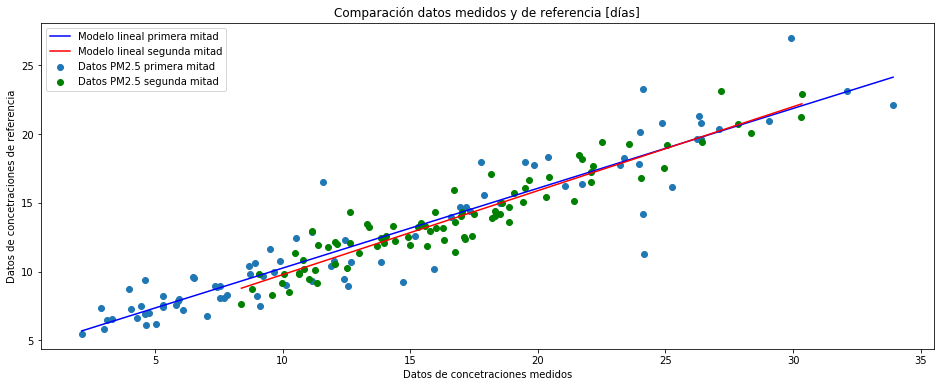

In [44]:
plt.figure(figsize=(16,6))
#Se grafican los puntos con las concetraciones PM2.5
plt.scatter(data_comparison_dia1["PM2.5_MED"], data_comparison_dia1["PM2.5_AMB"], label="Datos PM2.5 primera mitad")
plt.scatter(data_comparison_dia2["PM2.5_MED"], data_comparison_dia2["PM2.5_AMB"], c="green", label="Datos PM2.5 segunda mitad")
#Se grafican las rectas de ajuste.
plt.plot(x1_predict, y1_predict, 'b', label="Modelo lineal primera mitad")
plt.plot(x2_predict, y2_predict, 'r', label="Modelo lineal segunda mitad")
plt.title("Comparación datos medidos y de referencia [días]")
plt.xlabel("Datos de concetraciones medidos")
plt.ylabel("Datos de concetraciones de referencia")

plt.legend()
plt.show()

In [45]:
slope1, intercept = np.polyfit(x1_predict,y1_predict,1)
print(slope1)

slope2, intercept = np.polyfit(x2_predict,y2_predict,1)
print(slope2)

print((abs(slope1-slope2)/slope1)*100)

0.5800868911079926
0.6101815072678525
5.187949705668709


Meses:

In [46]:
data_comparison_mes1 = data_comparison_mes.iloc[0:4:]
data_comparison_mes2 = data_comparison_mes.iloc[4:8:]

In [47]:
X1 = np.array([np.ones(len(data_comparison_mes1["PM2.5_MED"])), data_comparison_mes1["PM2.5_MED"]]).T
a1 = inv(X1.T @ X1) @ X1.T @ data_comparison_mes1["PM2.5_AMB"] ### Fórmula para minimizar los cuadrados

In [48]:
### Predicción
x1_predict = np.linspace(data_comparison_mes1["PM2.5_MED"].min(), data_comparison_mes1["PM2.5_MED"].max(), num=100)
y1_predict = a1[0] + a1[1] * x1_predict ### Recta

In [49]:
X2 = np.array([np.ones(len(data_comparison_mes2["PM2.5_MED"])), data_comparison_mes2["PM2.5_MED"]]).T
a2 = inv(X2.T @ X2) @ X2.T @ data_comparison_mes2["PM2.5_AMB"] ### Fórmula para minimizar los cuadrados

In [50]:
### Predicción
x2_predict = np.linspace(data_comparison_mes2["PM2.5_MED"].min(), data_comparison_mes2["PM2.5_MED"].max(), num=100)
y2_predict = a2[0] + a2[1] * x2_predict ### Recta

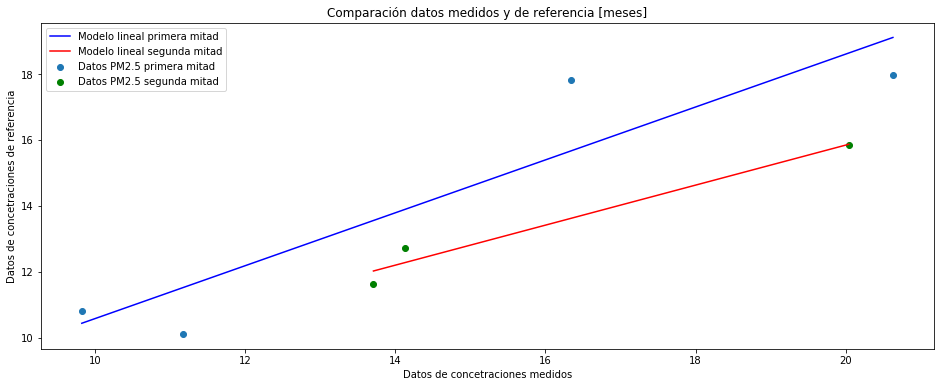

In [51]:
plt.figure(figsize=(16,6))
#Se grafican los puntos con las concetraciones PM2.5
plt.scatter(data_comparison_mes1["PM2.5_MED"], data_comparison_mes1["PM2.5_AMB"], label="Datos PM2.5 primera mitad")
plt.scatter(data_comparison_mes2["PM2.5_MED"], data_comparison_mes2["PM2.5_AMB"], c="green", label="Datos PM2.5 segunda mitad")
#Se grafican las rectas de ajuste.
plt.plot(x1_predict, y1_predict, 'b', label="Modelo lineal primera mitad")
plt.plot(x2_predict, y2_predict, 'r', label="Modelo lineal segunda mitad")
plt.title("Comparación datos medidos y de referencia [meses]")
plt.xlabel("Datos de concetraciones medidos")
plt.ylabel("Datos de concetraciones de referencia")

plt.legend()
plt.show()

In [52]:
slope1, intercept = np.polyfit(x1_predict,y1_predict,1)
print(slope1)

slope2, intercept = np.polyfit(x2_predict,y2_predict,1)
print(slope2)

print((abs(slope1-slope2)/slope1)*100)

0.8024912131812196
0.6071688250988548
24.33950489103447


Como se puede notar, el mejor modelo lineal es en escala de horas, por eso las pendientes de ambas rectas y su porcentaje de error fueron calculados a partir de esta escala.

### Histogramas

Algunos histogramas que muestran la distribución de los datos medidos y de referencia.

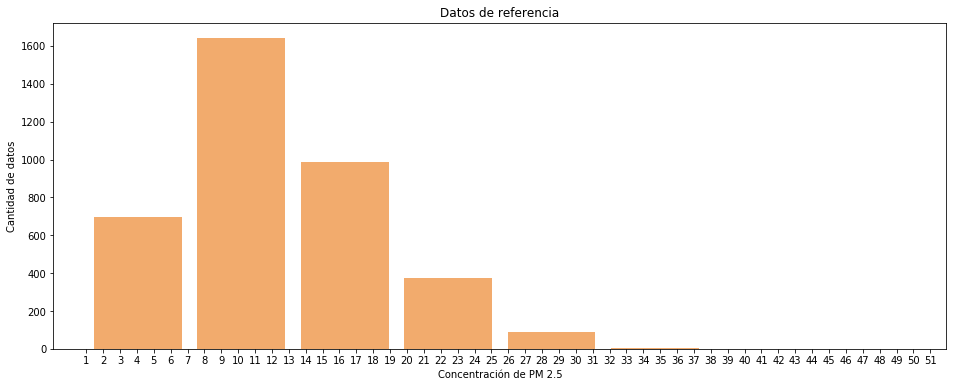

In [53]:
datos = pd.Series(data_comparison_hora["PM2.5_AMB"].astype(int)) # cargamos los datos en un objeto Series
intervalos = range(min(datos), max(datos) + 2)  # calculamos los extremos de los intervalos

plt.figure(figsize=(16,6))
datos.plot.hist(bins=8, color='#F2AB6D', rwidth=0.85) # generamos el histograma a partir de los datos
plt.xticks(intervalos)
plt.ylabel('Cantidad de datos')
plt.xlabel('Concentración de PM 2.5')
plt.title('Datos de referencia')

plt.show()

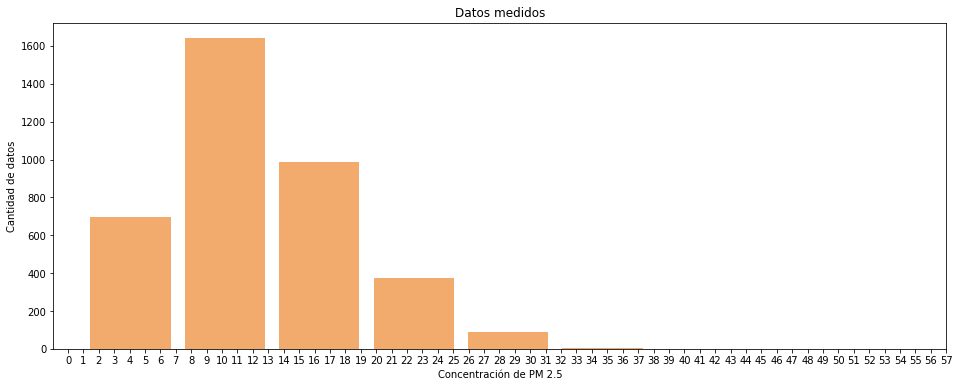

In [54]:
datos1 = pd.Series(data_comparison_hora["PM2.5_MED"].astype(int)) # cargamos los datos en un objeto Series
intervalos1 = range(min(datos1), max(datos1) + 2)  # calculamos los extremos de los intervalos

plt.figure(figsize=(16,6))
datos.plot.hist(bins=8, color='#F2AB6D', rwidth=0.85) # generamos el histograma a partir de los datos
plt.xticks(intervalos1)
plt.ylabel('Cantidad de datos')
plt.xlabel('Concentración de PM 2.5')
plt.title('Datos medidos')

plt.show()